<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Scan-over-number-of-perturbations" data-toc-modified-id="Scan-over-number-of-perturbations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scan over number of perturbations</a></span></li><li><span><a href="#Single-solution-in-detail" data-toc-modified-id="Single-solution-in-detail-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Single solution in detail</a></span><ul class="toc-item"><li><span><a href="#Prepare-graphs" data-toc-modified-id="Prepare-graphs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare graphs</a></span></li></ul></li><li><span><a href="#Exploration-of-the-solution-pools" data-toc-modified-id="Exploration-of-the-solution-pools-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploration of the solution pools</a></span></li><li><span><a href="#Leave-one-out-cross-validation" data-toc-modified-id="Leave-one-out-cross-validation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Leave-one-out cross-validation</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cnr
import cnr.cnrplot
import networkx as nx
import pickle

%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
%matplotlib inline

vaco_wt = pd.read_csv('out/cnr-input/vaco_wt_median_lfc.tsv', sep="\t", index_col=0)
vaco_ko = pd.read_csv('out/cnr-input/vaco_ko_median_lfc.tsv', sep="\t", index_col=0)
vaco_pe = pd.read_csv('out/cnr-input/vaco_pe_median_lfc.tsv', sep="\t", index_col=0)

## Data preparation

Select the nodes to include in the network reconstruction. Only use nodes that are in the (perturbed) MAPK and AKT pathway

In [2]:
REF_NODES = ['EGFR', # RTKs
             'MEK', 'ERK', 'P90RSK', 'GSK3AB', 'RPS6', #MAPK
             'PI3K', 'AKT', 'MTOR' # AKT
            ]

vaco_wt = vaco_wt.loc[REF_NODES]
vaco_ko = vaco_ko.loc[REF_NODES]
vaco_pe = vaco_pe.loc[REF_NODES]

col_wt = '#f2b561'
col_ko = '#ef6060'
col_pe = '#8dbeb2'

Prepare the annotations for CNR:

  * ALLOWED_INTERACTIONS: Restrict network to known interactions.
  * POSITIVE_INTERACTIONS, NEGATIVE_INTERACTIONS, POSITIVE_PERTURBATIONS and NEGATIVE_PERTURBATIONS are used to add constraints on the signs of the parameters.
  * TARGETS: what are the direct targets of the perturbations?
  * DOWNSTREAM_ACTING_PERTS: perturbations that don't affect the phosphorylation level of the target itself, but it's kinase activity.

In [3]:
ALLOWED_INTERACTIONS = [
    ('MEK', 'EGFR'), ('PI3K', 'EGFR'), ('AKT', 'EGFR'), # EGFR
    ('ERK', 'MEK'),  # MEK
    ('MEK', 'ERK'), ('EGFR', 'ERK'), ('P90RSK', 'ERK'), ('RPS6', 'ERK'), # ERK
    ('GSK3AB', 'P90RSK'),  # P90RSK
    # GSK3AB
    ('PI3K', 'RPS6'), ('MTOR','RPS6'),  # RPS6
    ('AKT', 'PI3K'),
    ('MTOR', 'AKT'), ('GSK3AB', 'AKT'), # AKT
    ('RPS6', 'MTOR'), ('AKT', 'MTOR'),  # MTOR
    #('CJUN', 'JNK') # JNK
]



POSITIVE_INTERACTIONS = [
    ('MEK', 'EGFR'), ('PI3K', 'EGFR'), ('AKT', 'EGFR'), # EGFR
    ('ERK', 'MEK'),  # MEK
    ('P90RSK', 'ERK'), ('RPS6', 'ERK'), # ERK
    ('GSK3AB', 'P90RSK'),  # P90RSK
    # GSK3AB
    ('AKT', 'PI3K'), 
    ('MTOR', 'AKT'), ('GSK3AB', 'AKT'),  # AKT
    ('RPS6', 'MTOR'),# ('AKT', 'MTOR'),  # MTOR
]

NEGATIVE_INTERACTIONS = [
     ('MEK', 'ERK'), ('EGFR', 'ERK'), # ERK
     ('PI3K', 'RPS6')
]


POSITIVE_PERTURBATIONS = [
    ('egf', 'EGFR'),
    ('hgfpi3k', 'PI3K'), ('hgfakt', 'AKT'), ('hgfmek', 'MEK'), # ('hgfmekplx', 'MEK'),
    ('nrg1pi3k', 'PI3K'), ('nrg1akt', 'AKT'), ("nrg1mek", 'MEK'), #("nrg1mekplx", 'MEK')
]


NEGATIVE_PERTURBATIONS = [
    ('plx', 'MEK'),
    ('mek', 'ERK'),
    ('erk', 'ERK'), 
    ('pi3k', 'AKT'),
    ('akt', 'AKT') 
]

# Map perturbations to targets
TARGETS = {
    'egf': 'EGFR',
    # HGF
    'hgfpi3k': 'PI3K',
    'hgfakt': 'AKT',
    'hgfmek': 'MEK',
    # NRG1
    'nrg1pi3k': 'PI3K',
    'nrg1akt': 'AKT',
    'nrg1mek': 'MEK',
    # Inhibitors
    'plx': 'MEK',
    'mek': 'MEK',
    'erk': 'ERK',
    'pi3k': 'PI3K',
    'akt': 'AKT'
}

DOWNSTREAM_ACTING_PERTS = ["mek", "pi3k"]

perts = []
for p_name in vaco_wt.columns:
    p_annot = []
    p_lst = p_name.split(' + ')
    for p in p_lst:
        if (p == "hgf" or p == 'nrg1'):
            p_annot += [p+'pi3k', p+'akt', p+'mek']
        else:
            p_annot += [p]
    perts.append(p_annot)

In [4]:
pp = cnr.PerturbationPanel(REF_NODES, perts, TARGETS, DOWNSTREAM_ACTING_PERTS)
pp.add_cell_line('wt', vaco_wt)
pp.add_cell_line('ko', vaco_ko)
pp.add_cell_line('pe', vaco_pe)

Heatmaps of the perturbation data (Fig 3C). 
Note that the color-scheme is inverted compared to the manuscript.

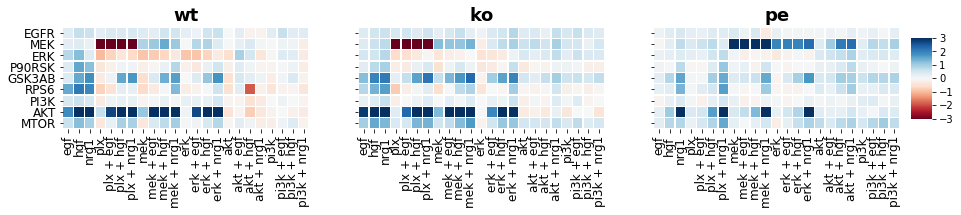

In [5]:
cnr.cnrplot.heatmap_cnr(pp.rglob, vmin=-3, vmax=3)

## Scan over number of perturbations

Determine resonable number of deviations.
Below, we will use all solution pools obtained in this scan to test the robustness of the identified differences.

In [6]:
%%capture
results = dict()
for md in range(0, 16):
    p = cnr.CnrProblem(pp, prior_network=ALLOWED_INTERACTIONS, maxdevs=md)

    p.set_edge_sign(POSITIVE_INTERACTIONS, 'pos')
    p.set_edge_sign(NEGATIVE_INTERACTIONS, 'neg')

    p.set_pert_sign(POSITIVE_PERTURBATIONS, 'pos')
    p.set_pert_sign(NEGATIVE_PERTURBATIONS, 'neg')

    p.cpx.solve()
    results[md] = cnr.CnrResultPool(p)

with open("out/cnr-solutions/vaco-pools.pickle", "wb") as handle:
    pickle.dump(results, handle)

with open("out/cnr-solutions/vaco-pools.pickle", "rb") as handle:
    results = pickle.load(handle)

Figure S6: What is the relation between model fit and the number of differences per cell line?

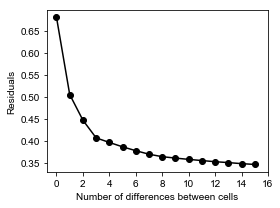

In [7]:
fig = plt.figure(1, figsize=(4, 3))
x, y = zip(*[(key, solpool.solutions[0].mssr) for key, solpool in results.items()])
plt.rc('font', family='Arial')
plt.plot(x, y, 'o-', color="black")
plt.xticks(range(0, 17, 2))
plt.xlabel('Number of differences between cells')
plt.ylabel('Residuals')
plt.tight_layout()

## Single solution in detail

In [117]:
prob = cnr.CnrProblem(pp, prior_network=ALLOWED_INTERACTIONS, maxdevs=6, maxints=16)

prob.set_edge_sign(POSITIVE_INTERACTIONS, 'pos')
prob.set_edge_sign(NEGATIVE_INTERACTIONS, 'neg')
prob.set_pert_sign(POSITIVE_PERTURBATIONS, 'pos')
prob.set_pert_sign(NEGATIVE_PERTURBATIONS, 'neg')


prob.cpx.solve()
prob.cpx.populate_solution_pool()
sol = cnr.CnrResult(prob)
sol.deviations_overview()

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 746.299566 after 0.00 sec. (0.06 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 51 rows and 19 columns.
Aggregator did 16 substitutions.
Reduced MIQP has 688 rows, 799 columns, and 2219 nonzeros.
Reduced MIQP has 28 binaries, 0 generals, 0 SOSs, and 84 indicators.
Reduced MIQP objective Q matrix has 619 nonzeros.
Presolve time = 0.01 sec. (1.54 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIQP has 688 rows, 799 columns, and 2219 nonzeros.
Reduced MIQP has 28 binaries, 0 generals, 0 SOSs, and 84 indicators.
Reduced MIQP objective Q matrix has 619 nonzeros.
Presolve time = 0.01 sec. (0.73 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.04 sec. (8.64 ticks)

        Nodes                                  

,wt,ko,pe,mean
r_AKT_EGFR,4.39299,1.7623,0,2.05176
r_MEK_EGFR,0.560493,0.842991,5.70573,2.36974
r_MEK_ERK,-0.400376,-0.459376,-2.16569,-1.00848
rp_akt_AKT,-1.13651,-3.00657,-2.17213,-2.10507
rp_nrg1mek_MEK,0,0.637866,1.81104,0.816301
rp_plx_MEK,-6.12197,-6.81817,-0.903124,-4.61442


In [126]:
np.corrcoef(
    sol.rglob['wt'].melt().value,
    sol.rglob_predicted['wt'].melt().value)
    
#corrwith(sol.rglob_predicted['wt'].melt()

array([[1.        , 0.72819591],
       [0.72819591, 1.        ]])

### Prepare graphs

Write the obtained solution to a .gml file for visualization using cytoscape.
These files are written to the folder out/graphs
This folder also contains the cytoscape file style needed to create Fig 4A.

In [9]:
graph_pos = {
    'EGFR': (0.5, -1.),#MAPK
    'MEK': (0, -2), 
    'ERK': (0, -4), 
    'P90RSK': (0, -6), 
    'GSK3AB': (0, -8),
    'RPS6': (1, -8), 
    'PI3K': (1, -2), 
    'AKT': (1, -4), 
    'MTOR': (1, -6), # AKT
    # Pertubation
    'hgf': (0.25, 1),
    'nrg1': (0.75, 1),
    'egf': (0.5, 1),
    'pi3k': (1.25, -2.),
    'erk': (.375, -4.), 
    'plx': (-0.275, 0.5),
    'mek': (-.275, -2.),
    'akt': (.625, -4.)
}

# This is a function to merge several nodes into one in a Networkx graph

def merge_nodes(G, nodes, new_node):
    """
    Merges the selected `nodes` of the graph G into one `new_node`,
    meaning that all the edges that pointed to or from one of these
    `nodes` will point to or from the `new_node`.
    attr_dict and **attr are defined as in `G.add_node`.
    """
    G.add_node(new_node, type= "perturbation") # Add the 'merged' node  
    new_edges = []
    for n1, n2, data in G.edges(data=True):
        # For all edges related to one of the nodes to merge,
        # make an edge going to or coming from the `new gene`.
        if n1 in nodes:
            new_edges.append((new_node, n2, data))
        elif n2 in nodes:
            new_edges.append((n1, new_node,data))
    G.add_edges_from(new_edges)
    
    for n in nodes: # remove the merged nodes
        G.remove_node(n)


def write_perturbation_gml(G_original, graph_pos, fname, nodes_drop=None, highlight_diff = True):
    G = G_original.copy()
    pos_x = dict()
    pos_y = dict()
    for key, val in graph_pos.items():
        pos_x[key] = int(150*val[0])
        pos_y[key] = int(-30*val[1])

    pert_type = {
        'hgf': "stim",
        'nrg1': 'stim',
        'egf': 'stim', 
        'pi3k': 'inhib',
        'erk': 'inhib',
        'plx': 'inhib',
        'mek': 'inhib',
        'akt': 'inhib',  
    }  
    
    # Merge nodes originating from same perturbation
    mergedict = {
    'nrg1': [n for n in G.nodes() if n.startswith('nrg1')],
    'hgf': [n for n in G.nodes() if n.startswith('hgf')]
    }
    
    for new_node, nodes in mergedict.items():
        merge_nodes(G, nodes, new_node)
    nx.set_node_attributes(G, pos_x, name = 'x')
    nx.set_node_attributes(G, pos_y, name = 'y')
    nx.set_node_attributes(G, pert_type, name = 'ptype')
    
    nx.set_node_attributes(G, {'nrg1': 'perturbation', 'hgf': 'perturbation'}, 'type')

    G = nx.relabel_nodes(G, {'plx': 'braf'})

    if nodes_drop:
        G.remove_nodes_from(nodes_drop)
        
    if highlight_diff:
        for parent, child in G.edges():
            if G[parent][child]['deviation'] == 0.:
                G[parent][child]['color'] = 'gray'

    nx.write_gml(G, fname)

In [10]:
# Merge nodes originating from same perturbation
gdict = {cl: cnr.cnrplot.graph_from_sol(sol, cl, widthfactor=2) for cl in sol.cell_lines}

for cl, graph in gdict.items():
    filename = 'out/graphs/vaco-' + cl + '.gml'
    g = write_perturbation_gml(graph, graph_pos, filename)

##  Exploration of the solution pools

In [11]:
with open("out/cnr-solutions/vaco-pools.pickle", "rb") as handle:
    pickle.load(handle)

Total number of solutions with an objective value less than 150% of the best (for each number of allowed differences)

In [12]:
cum_nsols = 0
for solpool in results.values():
    ovals = list(solpool.objective_values.values())
    for o in ovals:
        if o <= 1.5 * ovals[0]:
            cum_nsols += 1
cum_nsols

150

In [13]:
keys = solpool.solutions[0].allowed_deviations.keys()
deviationsCount = dict(zip(keys, len(keys)*[0]))

best_objective_val = solpool.objective_values[0]
for solpool in results.values():
    for solidx, sol in solpool.solutions.items():
        # Only use solutions with objective value close to optimal
        if sol.objective_value < 1.5 * best_objective_val:
            for key, val in sol.allowed_deviations.items():
                deviationsCount[key] += val


An overview of the edges that deviate in most solutions.
(NB: These results are slightly different as presented in the manuscript.
This is presumably due to an update in the version of CPLEX used.
While the optimal-solution is cannot change, how the solution pool is populated might differ slightly between versions.
Importantly, the same differences are recurrently found. 
The only thing that changes slightly are the fraction of occurences.)

In [14]:
df = pd.DataFrame.from_dict(deviationsCount, orient="index")
df.index.name = 'indicator'
df = df.sort_values(0, ascending=False)
df.columns = ['occurrences']
df["fraction"] = np.round(df.occurrences/cum_nsols, 2)
df.iloc[0:5].to_csv("~/Desktop/test.tsv", sep = "\t")
df.iloc[0:5]


,occurrences,fraction
indicator,,
IrpDev_plx_MEK,145.0,0.97
IDev_AKT_EGFR,126.0,0.84
IrpDev_nrg1mek_MEK,114.0,0.76
IDev_MEK_EGFR,112.0,0.75
IDev_MEK_ERK,102.0,0.68


In [15]:

def deviationDistribution(res, devName):
    if devName.split('_')[0] == 'IDev':
        base = 'r'
    elif devName.split('_')[0] == 'IrpDev':
        base = 'rp'
    varName = '_'.join([base] + devName.split('_')[1:])
    df = pd.DataFrame(columns=['wt', 'ko', 'pe'], dtype=float)

    for key, solpool in res.items():
        for solidx, sol in solpool.solutions.items():
            dev = sol.deviations_overview()
            if varName in dev.index:
                tmp = dev.loc[varName]
                df = df.append(tmp)
    return df

def plotDeviationDistribution(res, devName, title = None, palette=None, columns = None):
    df = deviationDistribution(res, devName)
    #sns.set_style("white")
    sns.set_context("paper",  font_scale=1.125)
    df.columns = ['WT', "PTPN11 KO", 'Persister', "mean"]
    if not columns:
        fig = plt.figure(1, figsize=(3, 2));
        sns.boxplot(data=df[['WT', 'PTPN11 KO', 'Persister']],
                   palette = palette)
    else:
        fig = plt.figure(1, figsize=(4.5, 3));
        sns.boxplot(data=df[columns],
                   palette = palette)
        
    # plt.axhline(y=0, color='k')
#     if title is None:
#         title = devName
#     plt.title(title, fontweight='bold', size=8);
#     #plt.tight_layout()
    return plt


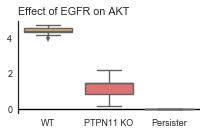

In [16]:
sns.set_context('paper')
sns.set_style("white")
plotDeviationDistribution(results, 'IDev_AKT_EGFR', palette=(col_wt, col_ko, col_pe))
plt.title('Effect of EGFR on AKT', loc="left")
sns.despine(bottom=True)
plt.axhline(0, color='black')
plt.tight_layout()

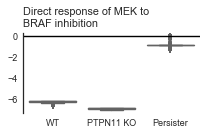

In [17]:
sns.set_context('paper')
plotDeviationDistribution(results, 'IrpDev_plx_MEK', palette=(col_wt, col_ko, col_pe))
plt.title('Direct response of MEK to\nBRAF inhibition', loc="left")
sns.despine(bottom=True)
plt.axhline(0, color='black')
plt.tight_layout()

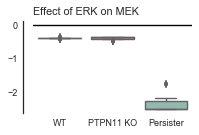

In [18]:
plotDeviationDistribution(results, 'IDev_MEK_ERK', palette=(col_wt, col_ko, col_pe))
plt.title('Effect of ERK on MEK', loc="left")
sns.despine(bottom=True, offset=10)
plt.axhline(0, color='black')
plt.tight_layout()

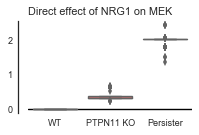

In [19]:
plotDeviationDistribution(results, 'IrpDev_nrg1mek_MEK', palette=(col_wt, col_ko, col_pe))
plt.title('Direct effect of NRG1 on MEK', loc="left")
sns.despine(bottom=True, offset=10)
plt.axhline(0, color='black')
plt.tight_layout()


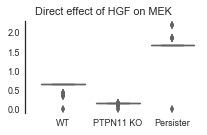

In [20]:
plotDeviationDistribution(results, 'IrpDev_hgfmek_MEK', palette=(col_wt, col_ko, col_pe))
plt.title('Direct effect of HGF on MEK', loc="left")
sns.despine(bottom=True, offset=10)
plt.tight_layout()


## Leave-one-out cross-validation

In [25]:
def loocv_train(test_col_name, prior_network):
    """Train model leaving out the column test_col_idx
    
    Parameters:
    test_col_idx: name of column to leave out
    given_edges: list of tuple indicating which edges are included.
    eta, theta, bounds: floats
    
    returns a tuple (test_col_idx, sol)
    """
    # Get name of Rglob column to remove
    test_col_name = vaco_wt.columns[test_col_idx]

    # Remove perturbation
    pert_copy = perts.copy()
    pert_copy.pop(test_col_idx)
    
    # Define the reduced perturbation panel
    train_panel = cnr.PerturbationPanel(
        REF_NODES, pert_copy, TARGETS, DOWNSTREAM_ACTING_PERTS,
        rglob = {
            'wt': vaco_wt.drop(test_col_name, axis=1),
            'ko': vaco_ko.drop(test_col_name, axis=1),
            'pe': vaco_pe.drop(test_col_name, axis=1),
        }
    )
    prob = cnr.CnrProblem(train_panel, prior_network=ALLOWED_INTERACTIONS,
                          maxdevs=6, maxints=16)
    prob.set_edge_sign(POSITIVE_INTERACTIONS, 'pos')
    prob.set_edge_sign(NEGATIVE_INTERACTIONS, 'neg')
    prob.set_pert_sign(POSITIVE_PERTURBATIONS, 'pos')
    prob.set_pert_sign(NEGATIVE_PERTURBATIONS, 'neg')

    prob.cpx.solve()
    return (test_col_name, cnr.CnrResult(prob))

In [27]:
tmp = loocv_train(0, prior_network=ALLOWED_INTERACTIONS)

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 735.921267 after 0.00 sec. (0.06 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 51 rows and 19 columns.
Aggregator did 16 substitutions.
Reduced MIQP has 661 rows, 772 columns, and 2141 nonzeros.
Reduced MIQP has 28 binaries, 0 generals, 0 SOSs, and 84 indicators.
Reduced MIQP objective Q matrix has 592 nonzeros.
Presolve time = 0.01 sec. (1.48 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIQP has 661 rows, 772 columns, and 2141 nonzeros.
Reduced MIQP has 28 binaries, 0 generals, 0 SOSs, and 84 indicators.
Reduced MIQP objective Q matrix has 592 nonzeros.
Presolve time = 0.01 sec. (0.70 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (8.37 ticks)

        Nodes                                  

In [42]:
%%capture
cols_to_test = [i for i in range(len(list(vaco_wt.columns))) 
                if "+" in list(vaco_wt.columns)[i]]
loocv_sols = [loocv_train(i, ALLOWED_INTERACTIONS) for i in cols_to_test]

In [57]:
def predict_combo(sol, combo):
    d = dict()
    for cl in ["wt", "ko", "pe"]:
        rpert = pd.DataFrame(index = sol.nodes)
        rpert[combo] = sol.rpert[cl][combo.split(" + ")].sum(axis = 1)
        rloc = sol.rloc[cl]
        mat =  -np.dot(np.linalg.inv(rloc), rpert)
        d[cl] = pd.DataFrame(mat, index = rpert.index, columns = rpert.columns)
    return d


def loocv_predict(loocv_sols):
    # Input is list of form combo-name (str), solution (CnrResult)
    prediction = {
        'wt': pd.DataFrame(index = loocv_sols[0][1].nodes),
        'ko': pd.DataFrame(index = loocv_sols[0][1].nodes),
        'pe': pd.DataFrame(index = loocv_sols[0][1].nodes)
    }
    
    for combo, sol in loocv_sols:
        p = predict_combo(sol, combo)
        prediction['wt'][combo] = p['wt']
        prediction['ko'][combo] = p['ko']
        prediction['pe'][combo] = p['pe']
    return prediction


[]

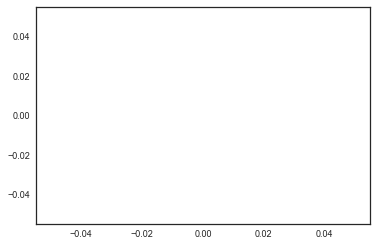

In [81]:
plt.plot(x=, y=)


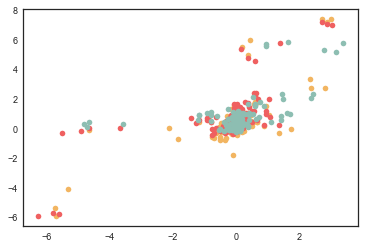

In [91]:
plt.plot(
    np.array(loocv_predict(loocv_sols)['wt']).flatten(),
    np.array(vaco_wt.iloc[:, cols_to_test]).flatten(),
    'o', color = col_wt
)
plt.plot(
    np.array(loocv_predict(loocv_sols)['ko']).flatten(),
    np.array(vaco_ko.iloc[:, cols_to_test]).flatten(),
    'o', color = col_ko
)
plt.plot(
    np.array(loocv_predict(loocv_sols)['pe']).flatten(),
    np.array().flatten(),
    'o', color = col_pe
)
    

In [98]:
combos = {
    "wt": vaco_wt.iloc[:, cols_to_test],
    "ko": vaco_ko.iloc[:, cols_to_test],
    "pe": vaco_pe.iloc[:, cols_to_test]
}

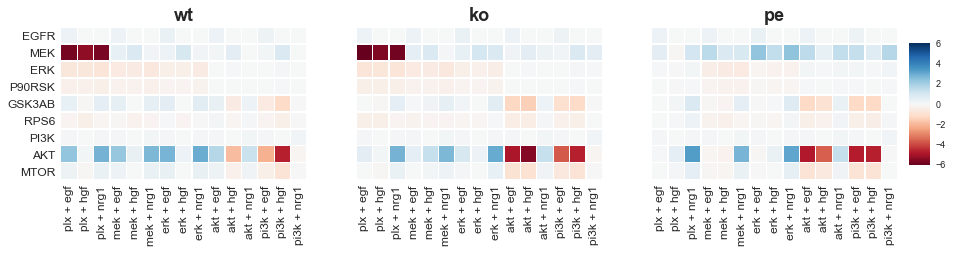

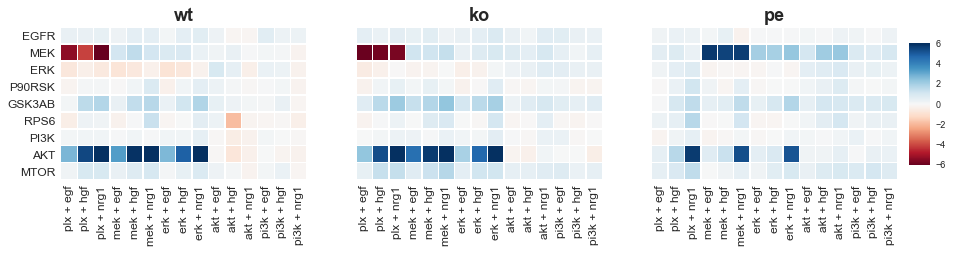

In [99]:
cnr.cnrplot.heatmap_cnr(loocv_predict(loocv_sols), vmin=-6, vmax=6)

cnr.cnrplot.heatmap_cnr(combos, vmin=-6, vmax=6)

In [104]:
""
np.corrcoef(
    np.array(loocv_predict(loocv_sols)['wt']).flatten(),
    np.array(vaco_wt.iloc[:, cols_to_test]).flatten()
)[0,1]
# np.corrcoef(
#     np.array(loocv_predict(loocv_sols)['wt']).flatten(),
#     np.array(vaco_wt.iloc[:, cols_to_test]).flatten()
# )
# np.corrcoef(
#     np.array(loocv_predict(loocv_sols)['wt']).flatten(),
#     np.array(vaco_wt.iloc[:, cols_to_test]).flatten()
# )
#     np.array(loocv_predict(loocv_sols)['ko']).flatten(),
#     np.array(vaco_ko.iloc[:, cols_to_test]).flatten(),
#     'o', color = col_ko
# )
# plt.plot(
#     np.array(loocv_predict(loocv_sols)['pe']).flatten(),
#     np.array().flatten(),
#     'o', color = col_pe
# )
#     )

0.7194685938521964

In [118]:
#np.array(sol.rglob["wt"]).flatten()


,EGFR,MEK,ERK,P90RSK,GSK3AB,RPS6,PI3K,AKT,MTOR
EGFR,-1.000000,-0.000000,-1.110223e-16,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
MEK,0.560493,-1.000000,-4.003758e-01,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
ERK,-0.000000,0.118298,-1.000000e+00,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
P90RSK,-0.000000,-0.000000,4.574468e-01,-1.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
GSK3AB,-0.000000,-0.000000,-0.000000e+00,0.349957,-1.0,-0.000000,-0.000000,0.255415,-0.000000
RPS6,-0.000000,-0.000000,4.686500e-01,-0.000000,-0.0,-1.000000,-0.000000,-0.000000,0.510700
PI3K,0.351489,-0.000000,-0.000000e+00,-0.000000,-0.0,0.000000,-1.000000,-0.000000,-0.000000
AKT,4.392992,-0.000000,-0.000000e+00,-0.000000,-0.0,-0.000000,0.042083,-1.000000,2.657003
MTOR,-0.000000,-0.000000,-0.000000e+00,-0.000000,-0.0,0.240535,-0.000000,0.152475,-1.000000
